<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

Reading original data

In [2]:
PATH_TO_DATA = ('../../data')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [3]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [4]:
import pickle

# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')


# Load websites dictionary
with open(os.path.join(PATH_TO_DATA, "site_dic.pkl"), "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
46946,i1-js-14-3-01-11074-498398316-i.init.cedexis-r...
40072,r14---sn-25ge7n7z.googlevideo.com
28842,31-events.olark.com
27988,blog.stade-rennais-online.com
22633,www.confusedmatthew.com


Separate target feature 

In [5]:
y = train_df['target']

In [6]:
train_sites = train_df[sites].values.flatten()
test_sites = test_df[sites].values.flatten()
good_sites = train_df[y == 0][sites].values.flatten()
bad_sites = train_df[y == 1][sites].values.flatten()

unique_train_sites = set(train_sites)
unique_test_sites = set(test_sites)
unique_good_sites = set(good_sites)
unique_bad_sites = set(bad_sites)

Time features

In [7]:
times = ['time%s' % i for i in range(1, 11)]
for time_id in times:
    train_df[time_id] = pd.to_datetime(train_df[time_id])

In [11]:
train_df.loc[:, 'h'] = train_df.loc[:, 'time1'].apply(lambda x: x.hour)
train_df.loc[:, 'hm'] = train_df.loc[:, 'time1'].apply(lambda x: x.hour * 100 + x.minute)

(6, 24)

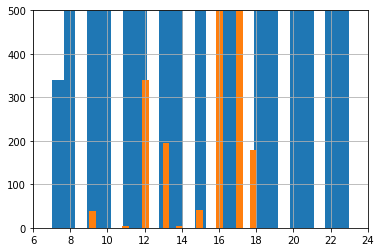

In [124]:
train_df[y == 0]['h'].hist(bins=25)
train_df[y == 1]['h'].hist(bins=25)
plt.ylim((0, 500))
plt.xlim((6, 24))

(0, 500)

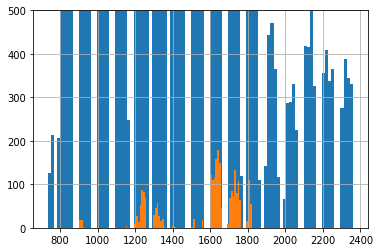

In [10]:
train_df[y == 0]['hm'].hist(bins=100)
train_df[y == 1]['hm'].hist(bins=100)
plt.ylim((0, 500))

## Create features

Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [283]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.sparse import hstack

def to_daytime(hour):
    if 7 <= hour < 9:
        return 0
    elif 9 <= hour < 11:
        return 1
    elif 11 <= hour < 14:
        return 2
    elif 14 <= hour < 17:
        return 3
    elif 17 <= hour < 20:
        return 4
    elif 20 <= hour < 24:
        return 5
    elif 0 <= hour < 4:
        return 6
    elif 4 <= hour < 7:
        return 7
    else:
        return -1


def is_not_weekend(weekday):
    return 0 if 5 <= weekday <= 6 else 1

def is_saturday(weekday):
    return 1 if 5 == weekday else 0

def is_sunday(weekday):
    return 1 if 6 == weekday else 0

    
def compute_timebased_features(df):
    df = df.copy()
    times = ['time%s' % i for i in range(1, 11)]
    for time_id in times:
        df[time_id] = pd.to_datetime(df[time_id])

    df.loc[:, 'daytime1'] = df.loc[:, 'time1'].apply(lambda x: to_daytime(x.hour))
    res1 = pd.get_dummies(df['daytime1'], prefix='daytime')
    res1['daytime_0'] = ~res1['daytime_0']
    res1['daytime_1'] = ~res1['daytime_1']
    res1['daytime_2'] = ~res1['daytime_2']
    res1['daytime_5'] = ~res1['daytime_5']    

    df.loc[:, 'h'] = df.loc[:, 'time1'].apply(lambda x: x.hour)
    res2 = pd.get_dummies(df['h'], prefix='h')
    res2 = ~res2
    
    df.loc[:, 'hm'] = df.loc[:, 'time1'].apply(lambda x: x.hour * 100 + x.minute)
    df.loc[:, 'hm'] = StandardScaler().fit_transform(df['hm'].values.reshape(-1, 1))
    
    df.loc[:, 'wd'] = df.loc[:, 'time1'].apply(lambda x: x.weekday())
    res3 = pd.get_dummies(df['wd'], prefix='wd')    
    
    df.loc[:, 'is_not_weekend'] = df.loc[:, 'time1'].apply(lambda x: is_not_weekend(x.weekday()))
    df.loc[:, 'is_not_saturday'] = df.loc[:, 'time1'].apply(lambda x: ~is_saturday(x.weekday()))
    df.loc[:, 'is_not_sunday'] = df.loc[:, 'time1'].apply(lambda x: ~is_sunday(x.weekday()))

    df.loc[:, 'session_duration'] = (df.loc[:, 'time10'] - df.loc[:, 'time1']).apply(lambda x: -x.seconds)
    df['session_duration'].fillna(0, inplace=True)
    df.loc[:, 'session_duration'] = StandardScaler().fit_transform(df['session_duration'].values.reshape(-1, 1))
    features = ['session_duration', 'daytime1', 'is_not_saturday', 'is_not_sunday', 'hm']
    return pd.concat([df[features], res1, res2, res3], axis=1)
#     return df[features]
    

In [284]:
# X = pd.concat([train_df[sites], compute_timebased_features(train_df)], axis=1)
X = compute_timebased_features(train_df)
X.shape

(253561, 35)

In [285]:
# X[y == 0]['session_duration'].hist(bins=50)
# X[y == 1]['session_duration'].hist(bins=50)

In [286]:
X.corrwith(y)

session_duration    0.024471
daytime1            0.085132
is_not_saturday     0.017586
is_not_sunday       0.016251
hm                  0.095489
daytime_0           0.032117
daytime_1           0.052764
daytime_2           0.009475
daytime_3           0.029156
daytime_4           0.101664
daytime_5           0.014514
h_7                 0.003509
h_8                 0.031880
h_9                 0.031388
h_10                0.037418
h_11                0.035169
h_12               -0.029982
h_13                0.001213
h_14                0.032679
h_15                0.023247
h_16               -0.112847
h_17               -0.095294
h_18               -0.048614
h_19                0.007474
h_20                0.006593
h_21                0.007867
h_22                0.007294
h_23                0.006966
wd_0                0.057825
wd_1                0.007103
wd_2               -0.047074
wd_3                0.009558
wd_4               -0.003013
wd_5               -0.017586
wd_6          

Perform cross-validation with logistic regression.

In [239]:
os.environ['JOBLIB_TEMP_FOLDER']="/tmp"

In [258]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=42)

class_weight = {
    0: 1,
    1: 12,
}

log_reg_cv = LogisticRegressionCV(cv=skf, scoring='roc_auc', 
                                  class_weight=class_weight,
                                  random_state=42, verbose=True, n_jobs=-1)

In [259]:
log_reg_cv.fit(X, y)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


LogisticRegressionCV(Cs=10, class_weight={0: 1, 1: 12},
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=42, refit=True, scoring='roc_auc', solver='lbfgs',
           tol=0.0001, verbose=True)

In [260]:
np.mean(log_reg_cv.scores_[1], axis=0), log_reg_cv.C_

(array([0.8504983 , 0.90831268, 0.92091632, 0.92386208, 0.9243786 ,
        0.92446758, 0.92447655, 0.92447849, 0.92447852, 0.9244783 ]),
 array([1291.54966501]))

In [261]:
y_pred = log_reg_cv.predict(X)

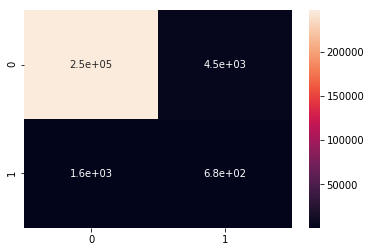

In [262]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

In [263]:
m

array([[246748,   4516],
       [  1612,    685]])

In [306]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict

class_weight = {
    0: 1,
    1: 10
}

skf = StratifiedKFold(n_splits=5, random_state=42)

max_depth_values = range(5, 10)
max_features_values = range(12, 17)
forest_params = {'max_depth': max_depth_values,
                 'max_features': max_features_values}
rf = RandomForestClassifier(class_weight=class_weight)

In [307]:
gs = GridSearchCV(rf, forest_params, scoring='roc_auc', cv=skf, n_jobs=10, verbose=True)
gs.fit(X, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed:   44.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'max_depth': range(5, 10), 'max_features': range(12, 17)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [308]:
gs.best_score_, gs.best_params_, gs.cv_results_['std_test_score'][gs.best_index_]

(0.9637551470061557,
 {'max_depth': 9, 'max_features': 16},
 0.0014692514993090388)

In [309]:
    rf = RandomForestClassifier(**gs.best_params_, class_weight=class_weight)
    rf.fit(X, y)
    y_pred = rf.predict(X)

In [310]:
from sklearn.metrics import confusion_matrix

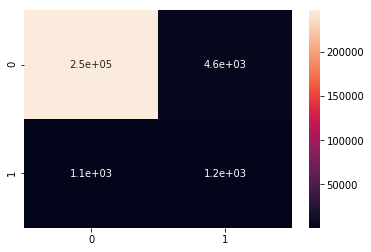

In [311]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

In [312]:
m

array([[246654,   4610],
       [  1063,   1234]])

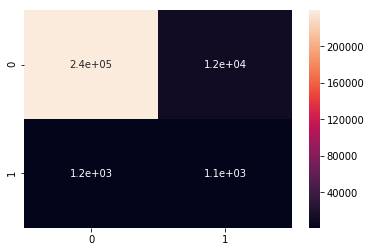

In [96]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

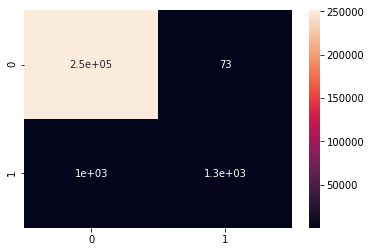

In [50]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

max_features=5000000, ngram_range=(1, 4) + ndaytimes + session duration

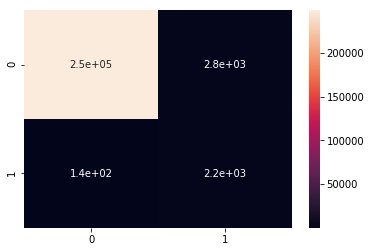

In [34]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

max_features=5000000, ngram_range=(1, 4)

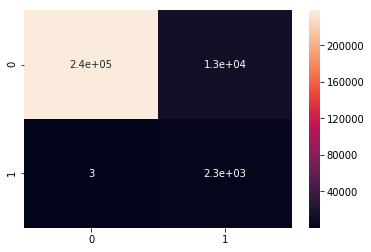

In [30]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

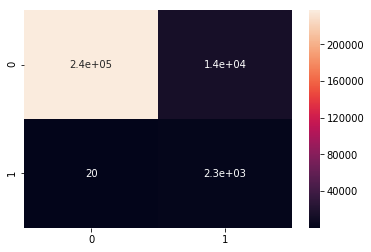

In [37]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

**Results:**

457510 tf-idf ngrams=(1,3) default tokenizer
```
(array([0.87793424, 0.89270005, 0.93151662, 0.96033089, 0.97152704,
        0.97398161, 0.97245746, 0.96887418, 0.96895329, 0.96782162]),
 array([2.7825594]))
 ```

378190 tfidf features ngrams=(1, 2)

`(array([0.88413484, 0.89676234, 0.92163549, 0.94630596, 0.95751679,
        0.95765139, 0.94786301, 0.93324887, 0.91174217, 0.91658067]),
 array([2.7825594]))`

100 tfidf site features

`array([0.84036089, 0.86739761, 0.88847426, 0.89525702, 0.89740772,
       0.89863011, 0.89907569, 0.89975907, 0.8995833 , 0.89978664])`

Site index custom tfidfs + ndaytimes

```
(array([0.761606  , 0.76186965, 0.76305951, 0.76328609, 0.76290517,
        0.76260131, 0.76257309, 0.7625813 , 0.76258039, 0.76259375]),
 array([0.04641589]))
```

Make prediction for the test set and form a submission file.

In [313]:
# X_test = add_timebased_features(test_sites_tfidf, test_df)
X_test = compute_timebased_features(test_df)

In [314]:
X_test.shape

(82797, 35)

In [318]:
test_probas = rf.predict_proba(X_test)
test_probas = test_probas[:, 1]
test_probas

array([0.00000000e+00, 0.00000000e+00, 7.10124263e-04, ...,
       6.38569604e-05, 0.00000000e+00, 0.00000000e+00])

In [319]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [320]:
write_to_submission_file(test_probas, "assignment6_alice_submission_model_rf_time_only_FN={}_FP={}_TP={}.csv"
                         .format(m[1, 0], m[0, 1], m[1, 1]))